# Temporal Convolutional Neural Network Evaluation

In [1]:
import os
from pathlib import Path

# Get the current notebook path
notebook_path = Path().resolve()

# Move to the parent directory of the current folder
parent_folder = notebook_path.parent

# Change the working directory to the right code folder
os.chdir(parent_folder)
print(f"Working directory changed to: {os.getcwd()}")

Working directory changed to: C:\Users\David\Documents\GitHub\DL25-Groep-DDDN\assignment 1\code


## Instantiating the model

In [2]:
import json

# get best parameters from tuning
with open("tcnn_model/tcnn_info/best_params.json", "r") as f:
    best_params = json.load(f)
print(best_params)

n_lags = best_params["n_lags"]
n_channels = best_params["n_channels"]
n_layers = best_params["n_layers"]
kernel_size = best_params["kernel_size"]
lr = best_params["lr"]

{'n_lags': 60, 'n_channels': 40, 'n_layers': 2, 'kernel_size': 3, 'lr': 0.007493750619726203}


In [3]:
from pytorch_tcn import TCN
import torch

# Instantiate the model using the found parameters
model = TCN(
    num_inputs= best_params["n_lags"],
    num_channels=[n_channels] * n_layers, 
    kernel_size=kernel_size,
    output_projection=1
    )

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing the data

In [4]:
from timeseries_split import (
    load_time_series,
    create_lagged_features,
    train_test_split_lagged,
    plot_lagged_chunks
)
import numpy as np

# Load and prepare
train_series = load_time_series("Xtrain.mat")
test_series = load_time_series("Xtest.mat", "Xtest")

# Normalization
train_mean = np.mean(train_series)
train_std = np.std(train_series)
train_series_norm = (train_series - train_mean) / train_std
test_series_norm = (test_series - train_mean) / train_std

#append the last part of the train_series (length 60) to the test set, used as input for prediction
last_60_train = train_series_norm[-60:]
test_series_norm = np.concatenate([last_60_train,test_series_norm])
train_lagged_df = create_lagged_features(train_series_norm, n_lags)
test_lagged_df = create_lagged_features(test_series_norm, n_lags)

In [5]:
# Tensorizing the training data
train_data = train_lagged_df.dropna()
X_train_df = train_data.drop("y", axis=1)
y_train_df = train_data["y"]
X_train = torch.FloatTensor(X_train_df.values).transpose(0, 1)
y_train = torch.FloatTensor(y_train_df.values)

# Tensorizing the testing data
test_data = test_lagged_df.dropna()
X_test_df = test_data.drop("y", axis=1)
y_test_df = test_data["y"]
X_test = torch.FloatTensor(X_test_df.values).transpose(0, 1)
y_test = torch.FloatTensor(y_test_df.values)


## Training the model

In [6]:
epochs = 330 # number of epochs is determined using manual tuning
train_losses = []
test_losses = []


for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds.squeeze(), y_train)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    model.eval()

    with torch.no_grad():
        test_preds = model(X_test)
        test_loss = criterion(test_preds.squeeze(), y_test)
        test_losses.append(test_loss.item())



#save the model
torch.save(model.state_dict(), "tcnn_model/tcnn_info/tcnn_model_weights.pth")


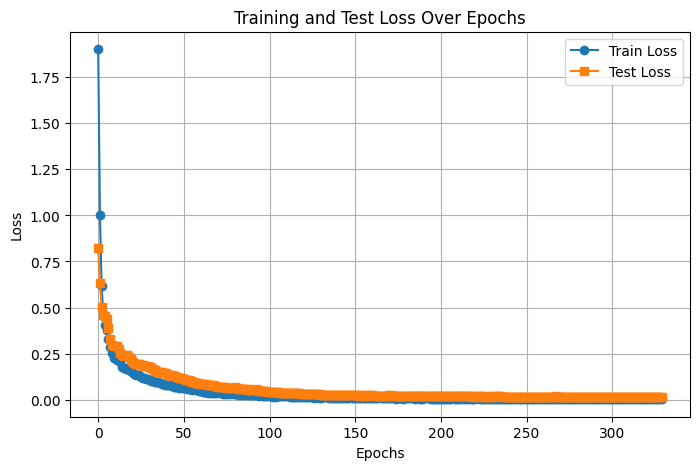

In [7]:
import matplotlib.pyplot as plt

# Plot showing the Train and test loss
epochs = range(0,330)
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='s')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation 

In [8]:
import matplotlib.pyplot as plt

# Detaching predictions and labels from gradients
y_pred = model(X_test).squeeze()
y_pred = y_pred.detach().cpu().numpy()
y_true = y_test.detach().cpu().numpy()

# Unnormalizing the predictions for plotting
y_pred = (y_pred * train_std) + train_mean
y_true = (y_true * train_std) + train_mean

#print the final loss (still normalized)
print(f"Final Test Loss (Normalized): {test_losses[-1]}")


Final Test Loss (Normalized): 0.014802847988903522


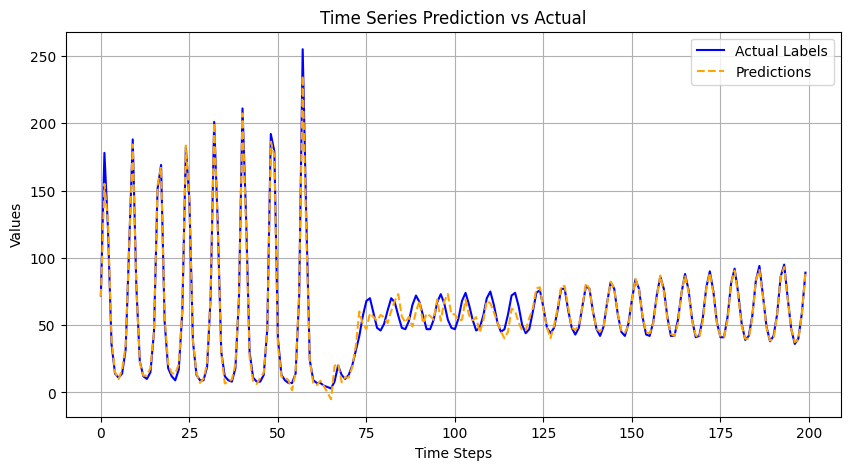

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Actual Labels', color='blue', linestyle='-', linewidth=1.5)
plt.plot(y_pred, label='Predictions', color='orange', linestyle='--', linewidth=1.5)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Time Series Prediction vs Actual')
plt.legend()
plt.grid(True)
plt.show()

## Recursive Prediction

In [10]:
# Recursively predicts over 200 steps
last_training_X = X_train[:, -1].unsqueeze(dim=1)
y_pred = model(last_training_X).detach()
y_pred

def recursive_prediction(n_steps=200, last_training_X=last_training_X):
    predictions = []
    last_X = last_training_X

    for _ in range(200):
        y_pred = model(last_X).detach()
        predictions.append(y_pred.item())
        last_X = torch.cat((last_X[1:], y_pred)) # remove first item of previous X, add prediction at the end

    return predictions

predictions = recursive_prediction()



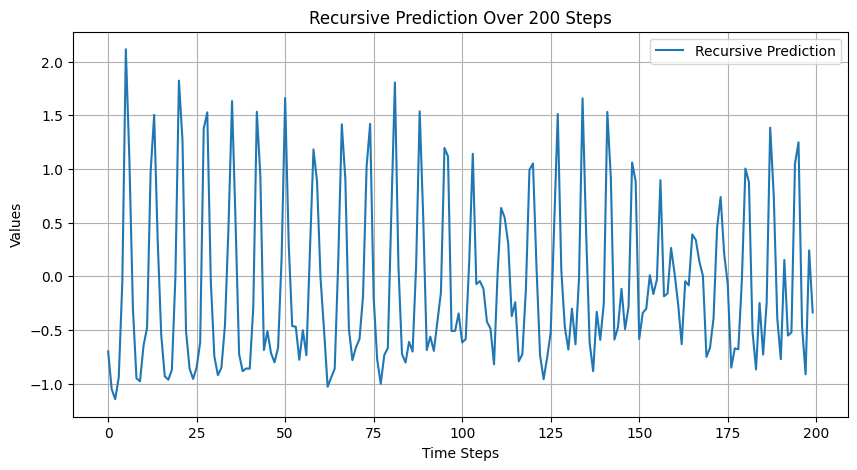

In [11]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(len(predictions)), predictions, label='Recursive Prediction')
plt.title('Recursive Prediction Over 200 Steps')
plt.xlabel('Time Steps')
plt.ylabel('Values')

plt.legend()
plt.grid(True)
plt.show()